In [ ]:
pip install tritonclient[all]

In [63]:
import tritonclient.http as tritonhttpclient
import tensorflow as tf

In [64]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

In [71]:
VERBOSE = False
input_name = 'input_3'
output_name = 'dense_11'
model_name = 'tensorrt_fp16_model'
url = '172.16.167.151:8000'
# if server and client are on different workstation, replace $localhost with IP address of the server
model_version = '1'

In [72]:
triton_client = tritonhttpclient.InferenceServerClient(url=url, verbose=VERBOSE)
model_metadata = triton_client.get_model_metadata(model_name=model_name, model_version=model_version)
model_config = triton_client.get_model_config(model_name=model_name, model_version=model_version)

In [73]:
path = '/shared-data/seminar/chest_xray/'
def process_data(img_dims, batch_size):
    
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(path + 'test' + cond)):
            img = plt.imread(path + 'test' + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return test_data, test_labels

In [74]:
img_dims = 150
epochs = 1
batch_size = 32

test_data, test_labels = process_data(img_dims, batch_size)

In [84]:
input_batch = test_data[218:250]
target_dtype = np.float16
input_batch = input_batch.astype(target_dtype)

input0 = tritonhttpclient.InferInput(input_name, (32,150, 150, 3), 'FP16')
input0.set_data_from_numpy(input_batch,binary_data=True)

output = tritonhttpclient.InferRequestedOutput(output_name, binary_data=True)
response = triton_client.infer(model_name, model_version=model_version, 
                               inputs=[input0], outputs=[output])

logits = response.as_numpy('dense_11')
logits = np.asarray(logits, dtype=np.float32)

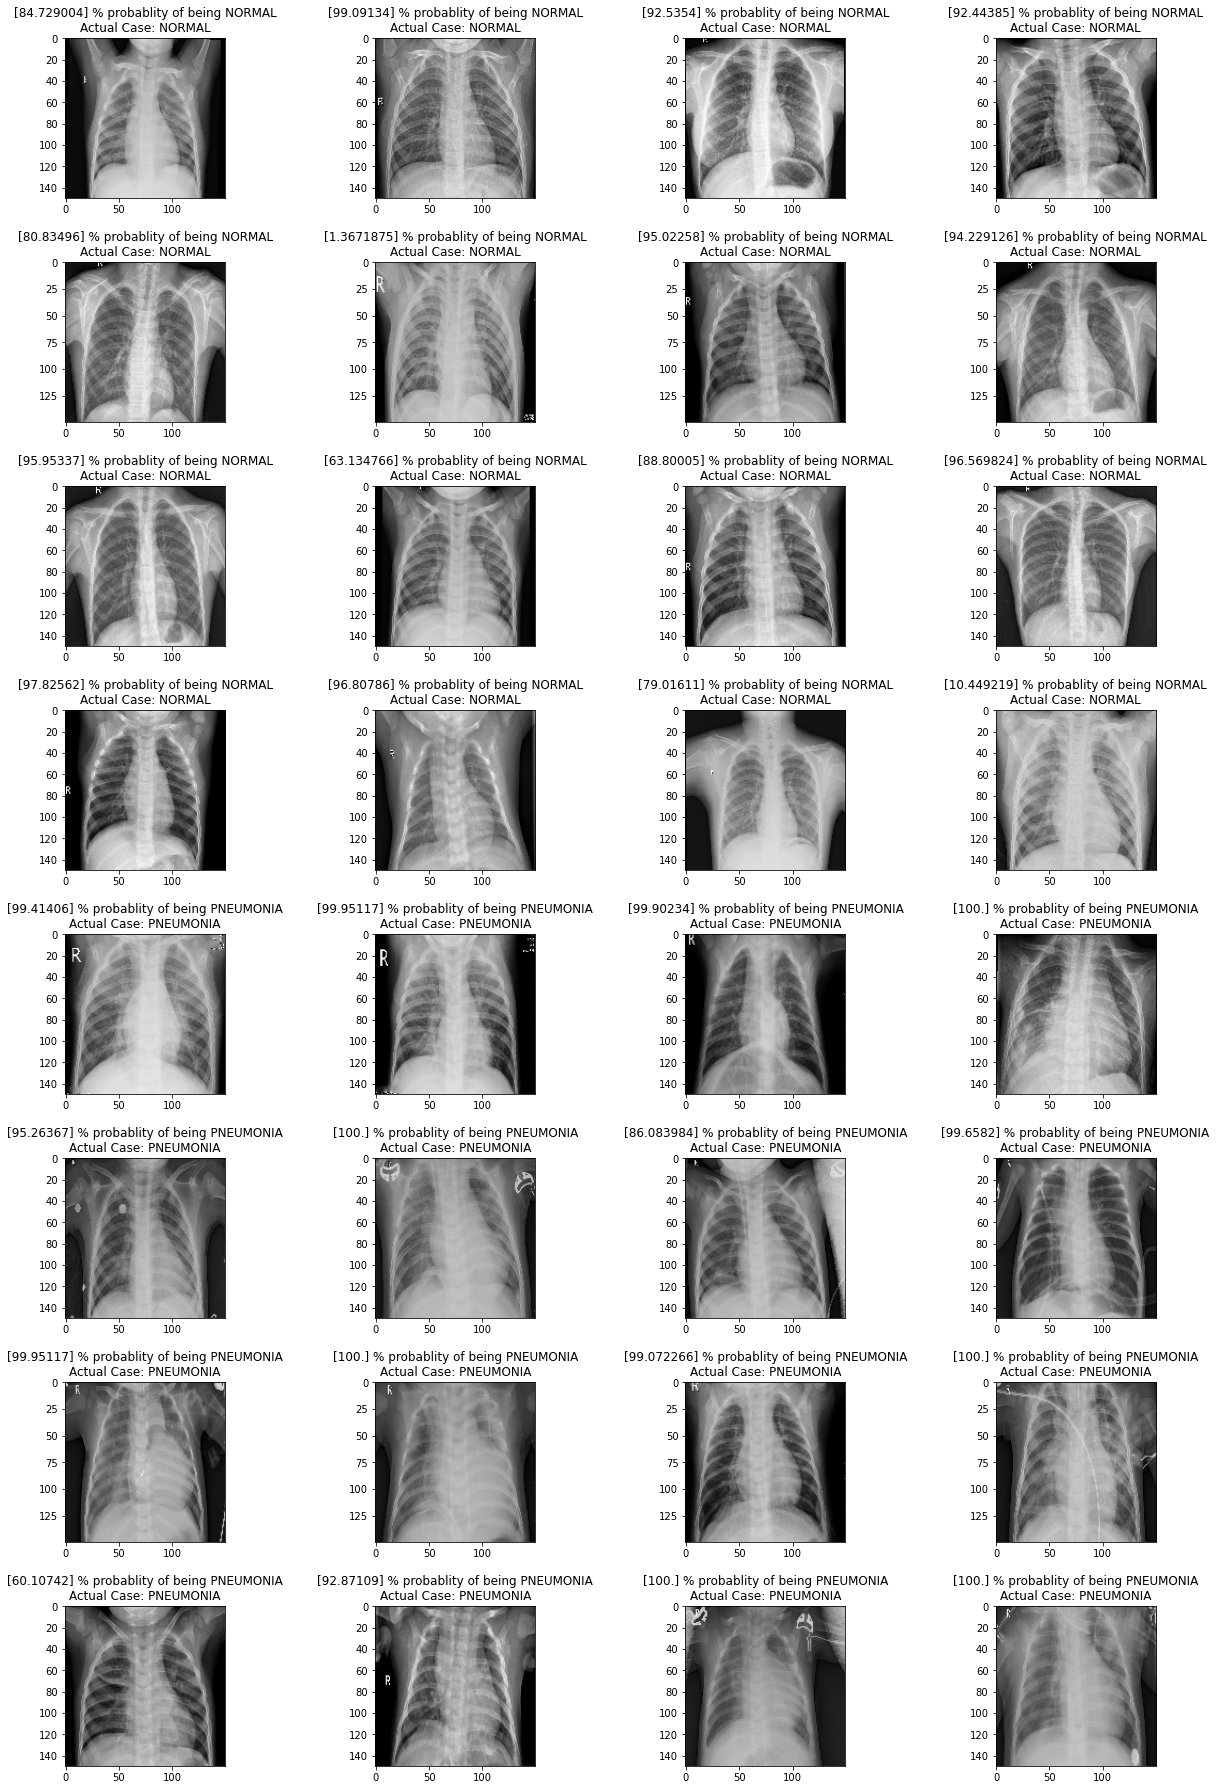

In [101]:
fig, ax = plt.subplots(8, 4, figsize=(20, 30))
ax = ax.ravel()
plt.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for i in range(32):
    j = i+218
    ax[i].imshow(test_data[j], cmap='gray')
    
    if test_labels[j] == 0:
        ax[i].set_title('{} % probablity of being NORMAL'.format((1 - logits[i])*100) + '\n' + 'Actual Case: NORMAL')
    else:
        ax[i].set_title('{} % probablity of being PNEUMONIA'.format(logits[i]*100) + '\n' + 'Actual Case: PNEUMONIA')